# How to use the NDDataArray class

## Introduction

This notebook explains how to use the class [gammapy.utils.nddata.NDDataArray](http://docs.gammapy.org/dev/api/gammapy.utils.nddata.NDDataArray.html)

The NDDataArray is basically an numpy array with associated axes and convenience methods for interpolation. For now 
only the scipy [RegularGridInterpolator](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.RegularGridInterpolator.html)
can be used, i.e. available interpolation methods are "nearest neighbour" and "linear". A spline interpolator
will be added in the future. The interpolation behaviour ("log", "linear") can be set for each axis individually.

The NDDataArray is currently used in the following classes

* [gammapy.irf.EffectiveAreaTable](http://docs.gammapy.org/dev/api/gammapy.irf.EffectiveAreaTable.html)
* [gammapy.irf.EffectiveAreaTable2D](http://docs.gammapy.org/dev/api/gammapy.irf.EffectiveAreaTable2D.html)
* [gammapy.irf.EnergyDispersion](http://docs.gammapy.org/dev/api/gammapy.irf.EnergyDispersion.html)
* [gammapy.spectrum.CountsSpectrum](http://docs.gammapy.org/dev/api/gammapy.spectrum.CountsSpectrum.html)
* Probably some more by now ...

Feedback welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from gammapy.utils.nddata import NDDataArray, DataAxis, BinnedDataAxis
from gammapy.utils.energy import Energy, EnergyBounds
import numpy as np
import astropy.units as u

## 1D example

Let's start with a simple example. A one dimensional array storing an exposure in ``cm-2 s-1`` as a function of energy. The energy axis is log spaced and thus also the interpolation shall take place in log.

In [3]:
energies = Energy.equal_log_spacing(10, 100, 10, unit=u.TeV)
x_axis = DataAxis(energies, name="energy", interpolation_mode="log")
data = np.arange(20, 0, -2) / u.cm ** 2 / u.s
nddata = NDDataArray(axes=[x_axis], data=data)
print(nddata)
print(nddata.axis("energy"))

NDDataArray summary info
energy         : size =    10, min = 10.000 TeV, max = 100.000 TeV
Data           : size =    10, min =  2.000 1 / (cm2 s), max = 20.000 1 / (cm2 s)

DataAxis
Name: energy
Unit: TeV
Nodes: 10
Interpolation mode: log


[ 10.          12.91549665  16.68100537  21.5443469   27.82559402
  35.93813664  46.41588834  59.94842503  77.42636827 100.        ] TeV


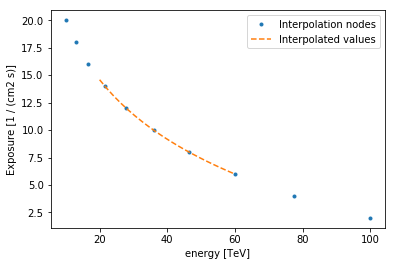

In [4]:
eval_energies = np.linspace(2, 6, 20) * 1e4 * u.GeV
eval_exposure = nddata.evaluate(energy=eval_energies, method="linear")

plt.plot(
    nddata.axis("energy").nodes.value,
    nddata.data.value,
    ".",
    label="Interpolation nodes",
)
print(nddata.axis("energy").nodes)
plt.plot(
    eval_energies.to("TeV").value,
    eval_exposure,
    "--",
    label="Interpolated values",
)
plt.xlabel("{} [{}]".format(nddata.axes[0].name, nddata.axes[0].unit))
plt.ylabel("{} [{}]".format("Exposure", nddata.data.unit))
plt.legend();

## 2D example

Another common use case is to store a Quantity as a function of field of view offset and energy. The following shows how to use the NDDataArray to slice the data array at any values of offset and energy

NDDataArray summary info
energy         : size =    50, min =  1.023 TeV, max =  9.772 TeV
offset         : size =     4, min =  0.000 deg, max =  2.000 deg
Data           : size =   200, min =  3.763 1 / (cm2 s TeV), max = 27.082 1 / (cm2 s TeV)



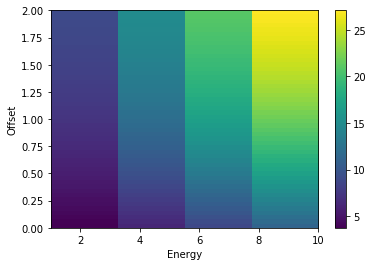

In [5]:
energy_data = EnergyBounds.equal_log_spacing(1, 10, 50, unit=u.TeV)
energy_axis = BinnedDataAxis(
    lo=energy_data.lower_bounds,
    hi=energy_data.upper_bounds,
    name="energy",
    interpolation_mode="log",
)
offset_data = np.linspace(0, 2, 4) * u.deg
offset_axis = DataAxis(offset_data, name="offset")

data_temp = 10 * np.exp(-energy_data.log_centers.value / 10)
data = np.outer(data_temp, (offset_data.value + 1))

nddata2d = NDDataArray(
    axes=[energy_axis, offset_axis], data=data * u.Unit("cm-2 s-1 TeV-1")
)

print(nddata2d)
extent_x = nddata2d.axis("energy").bins[[0, -1]].value
extent_y = nddata2d.axis("offset").nodes[[0, -1]].value
extent = extent_x[0], extent_x[1], extent_y[0], extent_y[1]
plt.imshow(nddata2d.data.value, extent=extent, aspect="auto")
plt.xlabel("Energy")
plt.ylabel("Offset")
plt.colorbar();

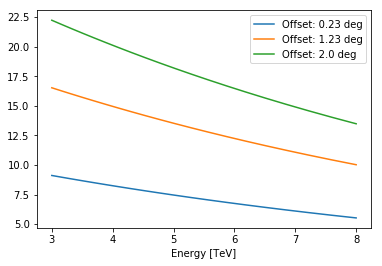

In [6]:
offsets = [0.23, 1.23, 2] * u.deg
eval_energies = Energy.equal_log_spacing(3, 8, 20, u.TeV)

for offset in offsets:
    slice_ = nddata2d.evaluate(offset=offset, energy=eval_energies)
    plt.plot(eval_energies.value, slice_, label="Offset: {}".format(offset))
plt.xlabel("Energy [TeV]")
plt.legend();